# NOTE

I DIDNT TEST THE FUNCTIONS GENERATING IMAGES  
i NEED TO CHECK HOW TO MODIFY IT IN THE NOAHS FUNCTION (IT LOOKS LIKE A ENCAPSULATED SESSION NOW).
MY ENVIROMENT ISN'T WORKING (CUDA AND NOW ANYTHING. rESINTALL IT)




Difference of this notebook to the previous baseline https://github.com/pinellolab/DNA-Diffusion/blob/dna-diffusion/notebooks/experiments/conditional_diffusion/dna_diff_baseline_conditional_UNET.ipynb

is time warping.

# Time warping (from https://arxiv.org/pdf/2211.15089.pdf)

The basic idea here is that we can smartly select the noise and use it to learn more efficiently. Selection of the noise happens through selecting optimal time values.

"we seek to determine a time reweighting
strategy that maximises sample quality. In practice,
this is best implemented through importance sampling:
rather than explicitly multiplying loss contributions
from different noise levels with a weighting function
𝜆(𝑡), we will instead sample 𝑡 from a non-uniform
distribution, whose density directly corresponds to
the desired relative weighting"

**What are optimal time values?**

"we will sample 𝑡 from a non-uniform
distribution, whose density directly corresponds to
the desired relative weighting"

**How does this distribution look like?**

"The entropy of the model predictions should
increase linearly as a function of 𝐹(𝑡)." Function we ought to estimate is the F(t).


**How will we approximate this function?**

According to the figure 2. and their description this function will approximate the Loss function of the UNET as the argument of the time. Hence we need to fit a model that approximates this. Once we have approximated this function we determine the inverse function, sample from it and perform importance sampling by multiplying the sampled values with the reciprocal of the derivative the CDF function F, which approximated the UNET loss. This corresponds then to the PDF (probability density function) since we created it when deriving the CDF.


**HOW DO WE KNOW THIS ACTUALLY WORKS FOR US?**

1. Almost all KL divergences improved (with fixed seed).
2. It was slowly debugged and cofirmed that we actually estimate the loss accordingly and sample the desired time values

Goal of this notebook is to clean up and structure the code from the initial great work: https://github.com/pinellolab/DNA-Diffusion/blob/dna-diffusion/notebooks/experiments/conditional_diffusion/easy_training_Conditional_Code_to_refactor_UNET_ANNOTATED_v4%20(2).ipynb

This notebook is divided in following chapters:
1. [Utility functions](#utility_functions)
2. [Data import and preperation](#Data-import-and-preperation)
3. [Stable Diffusion architecture](##Stable-Diffusion-architecture)
4. [Stable Diffusion training metric functions and evaluation](##Stable-+-Diffusion-+-training-+-metric-+-functions-+-and-+-evaluation)

Concrete improvements from the previous notebook:

1. Complete restructuring and refactoring of the code.
2. Delete unecessary code
4. Seed set for complete reproducibility (such that we know when improvements are really improving and not due to randomness)
5. Decoupled the logic between data loading and processing
6. Wrote doc strings for most of the classes and functions
7. Exposed hyperparameters immediately at the beggining (for easier hydra refactoring)
8. Added more functionality (such as injectable/interchangable metric functions etc.)
9. Documented all of the main chapters and subchapters, with brief theoretical description behind stable diffusion, architecture tackled there, classifier-Free Diffusion Guidance and EMEA.


**NOTE**: 

1. KL and other metrics remained the same or improved.
2. When calculating KL we are measuring occurances of particular motifs. That means we are not measuring distribution between "letters". This was the assumption from the original nb. We are also not measuring occurances at particular place, just wether and how much a motif occures between the train and test.


The main goal of this notebook is:

1. Set a major pre refactoring step such that we can easily move this to code base.
2. Set an easier entry point to newcomers.
3. Server as the new benchmark for prototyping.
4. As the refactoring is ongoing all of the code here should be abstracted away from imports from the codebase.



In [ ]:
#!mamba install -c conda-forge torchmetrics -y

# Optional libraries that need to be installed:

In [1]:
!pip install einops
!pip install torchmetrics
!pip install gimmemotifs
!genomepy install hg38
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 9.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 70.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

11:59:47 | INFO | Downloading assembly summaries from GENCODE
12:00:03 | INFO | Downloading assembly summaries from UCSC
12:00:07 | INFO | Downloading assembly summaries from Ensembl
12:00:21 | INFO | Downloading genome from UCSC. Target URL: http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz...
Download: 100% 938M/938M [00:31<00:00, 31.6MB/s]
12:00:52 | INFO | Genome download successful, starting post processing...
12:01:18 | INFO | name: hg38
12:01:18 | INFO | local name: hg38
12:01:18 | INFO | fasta: /root/.local/share/genomes/hg38/hg38.fa
Filtering Fasta: 64.2M lines [00:34, 1.84M lines/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing the dependencies:

In [21]:
from scipy.optimize import fsolve
import os

os.getpid()
import sklearn
from functools import partial
from scipy.stats import zscore
import torch
import copy
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt

# from tqdm.auto import tqdm
from tqdm import tqdm
from einops import rearrange
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image
from typing import List, Union
from torchmetrics.functional import kl_divergence
import random
import gc
from livelossplot import PlotLosses
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from IPython.core.debugger import set_trace

%matplotlib inline
import warnings

# this comes from inverting the CDF function in time warping procedure. Essentially it has to do with good selection of the starting point
# for the inversion algorithm. This was checked and it worked, hence safe to ignore: https://stackoverflow.com/questions/13057022/python-scipy-optimize-using-fsolve-with-multiple-first-guesses
warnings.filterwarnings('ignore', 'The iteration is not making good progress')

In [3]:
# !pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install  scikit-learn -y

In [4]:
#!mamba install -c anaconda cudatoolkit -y
#!mamba install pyg -c pyg -y
#!pip uninstall torch      -y
#!mamba install -c intel scikit-learn -y
torch.cuda.is_available()

True

### **Hyperparameters** that are exposed and need to be abstracted through hydra like interface and/or (potentially) hyperoptimised:

In [5]:
# number of steps to perform standard training of UNET before beggining with time warping
N_STEPS = 10
# Global seed
GLOBAL_SEED = 42
# Nucleic acids encoding the motifs
NUCLEOTIDES = ['A', 'C', 'T', 'G']
# Number of samples to run the training, evaluation. Increase to get statistical significance
N_SAMPLES = 1000
# Enumarate cell names
ENUMARATED_CELL_NAME = '''7 Trophoblasts
5 CD8_cells
15 CD34_cells
9 Fetal_heart
12 Fetal_muscle
14 HMVEC(vascular)
3 hESC(Embryionic)
8 Fetal(Neural)
13 Intestine
2 Skin(stromalA)
4 Fibroblast(stromalB)
6 Renal(Cancer)
16 Esophageal(Cancer)
11 Fetal_Lung
10 Fetal_kidney
1 Tissue_Invariant'''.split(
    '\n'
)
# Cell names
CELL_NAMES = {int(x.split(' ')[0]): x.split(' ')[1] for x in ENUMARATED_CELL_NAME}
# Number of epochs to train for
EPOCHS = 1000
# save and compare metrics after specified epoch
SAVE_AND_SAMPLE_EVERY = 1
# show loss after speficied epoch
EPOCHS_LOSS_SHOW = 5
# Number of BP for the motif
IMAGE_SIZE = 200
# iamge channels, with us singular
CHANNELS = 1
# Learning rate
LEARNING_RATE = 1e-4
# timesteps for diffusion
TIMESTEPS = 50
# Number of resnet block groups in the UNET architecture
RESNET_BLOCK_GROUPS = 4
# Batch size
BATCH_SIZE = 64
# total number of components
TOTAL_CLASS_NUMBER = 17
# Do you want to use time warping to sample noise smartly, in an active learning setting
TIME_WARPING = True

In [6]:
def seed_everything(seed=GLOBAL_SEED):
    """ "
    Seed everything.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
seed_everything()

Download the data if you dont have it locally:

In [8]:
# # #downloading data
# !wget https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2
# # #changing name
# !mv   train_all_classifier_WM20220916.csv.gz?dl=2 train_all_classifier_WM20220916.csv.gz
# # #unpcaking
# !gunzip -d /train_all_classifier_WM20220916.csv.gz?dl=2 train_all_classifier_WM20220916.csv
# # #new seqs

Mount the drive if you are using data from it:

#Utility functions

In [9]:
def motif_scoring_KL_divergence(original: pd.Series, generated: pd.Series) -> torch.Tensor:
    """
    This function encapsulates the logic of evaluating the KL divergence metric
    between two sequences.
    Returns
    -------
    kl_divergence: Float
    The KL divergence between the input and output (generated)
    sequences' distribution
    """

    kl_pq = kl_div(original, generated)
    return np.sum(kl_pq)


def motif_scoring_JS_divergence(original: pd.Series, generated: pd.Series) -> torch.Tensor:
    """
    This function encapsulates the logic of evaluating the Jensen-Shannon divergence metric
    between two sequences.
    Returns
    -------
    JS_divergence: Float
    The JS divergence between the input and output (generated)
    sequences' distribution
    """

    js_pq = jensenshannon(original, generated)
    return np.sum(js_pq)

In [10]:
def compare_motif_list(
    df_motifs_a, df_motifs_b, motif_scoring_metric=motif_scoring_KL_divergence, plot_motif_probs=True
):
    """
    This function encapsulates the logic of evaluating the difference between the distribution
    of frequencies between generated (diffusion/df_motifs_a) and the input (training/df_motifs_b) for an arbitrary metric ("motif_scoring_metric")

    Please note that some metrics, like KL_divergence, are not metrics in official sense. Reason
    for that is that they dont satisfy certain properties, such as in KL case, the simmetry property.
    Hence it makes a big difference what are the positions of input.
    """
    set_all_mot = set(df_motifs_a.index.values.tolist() + df_motifs_b.index.values.tolist())
    create_new_matrix = []
    for x in set_all_mot:
        list_in = []
        list_in.append(x)  # adding the name
        if x in df_motifs_a.index:
            list_in.append(df_motifs_a.loc[x][0])
        else:
            list_in.append(1)

        if x in df_motifs_b.index:
            list_in.append(df_motifs_b.loc[x][0])
        else:
            list_in.append(1)

        create_new_matrix.append(list_in)

    df_motifs = pd.DataFrame(create_new_matrix, columns=['motif', 'motif_a', 'motif_b'])

    df_motifs['Diffusion_seqs'] = df_motifs['motif_a'] / df_motifs['motif_a'].sum()
    df_motifs['Training_seqs'] = df_motifs['motif_b'] / df_motifs['motif_b'].sum()
    if plot_motif_probs:
        plt.rcParams["figure.figsize"] = (3, 3)
        sns.regplot(x='Diffusion_seqs', y='Training_seqs', data=df_motifs)
        plt.xlabel('Diffusion Seqs')
        plt.ylabel('Training Seqs')
        plt.title('Motifs Probs')
        plt.show()

    return motif_scoring_metric(df_motifs['Diffusion_seqs'].values, df_motifs['Training_seqs'].values)

In [11]:
def metric_comparison_between_components(original_data, generated_data, cell_components, x_label_plot, y_label_plot):
    """
    This functions takes as inputs dictionaries, which contain as keys different components (cell types)
    and as values the distribution of occurances of different motifs. These two dictionaries represent two different datasets, i.e.
    generated dataset and the input (train) dataset.

    The goal is to then plot a the main evaluation metric (KL or otherwise) across all different types of cell types
    in a heatmap fashion.
    """
    final_comparison_all_components = []
    for components_1, motif_occurance_frequency in original_data.items():
        comparisons_single_component = []
        for components_2 in generated_data.keys():
            compared_motifs_occurances = compare_motif_list(motif_occurance_frequency, generated_data[components_2])
            comparisons_single_component.append(compared_motifs_occurances)

        final_comparison_all_components.append(comparisons_single_component)

    plt.rcParams["figure.figsize"] = (10, 10)
    df_plot = pd.DataFrame(final_comparison_all_components)
    df_plot.columns = [CELL_NAMES[x] for x in cell_components]
    df_plot.index = df_plot.columns
    sns.heatmap(df_plot, cmap='Blues_r', annot=True, lw=0.1, vmax=1, vmin=0)
    plt.title(f'Kl divergence \n {x_label_plot} sequences x  {y_label_plot} sequences \n MOTIFS probabilities')
    plt.xlabel(f'{x_label_plot} Sequences  \n(motifs dist)')
    plt.ylabel(f'{y_label_plot} \n (motifs dist)')

In [12]:
def one_hot_encode(seq, nucleotides, max_seq_len):
    """
    One-hot encode a sequence of nucleotides.
    """
    seq_len = len(seq)
    seq_array = np.zeros((max_seq_len, len(nucleotides)))
    for i in range(seq_len):
        seq_array[i, nucleotides.index(seq[i])] = 1
    return seq_array

In [13]:
def log(t, eps=1e-20):
    """
    Toch log for the purporses of diffusion time steps t.
    """
    return torch.log(t.clamp(min=eps))

**EMA (exponential moving average)**
 the idea is that you have two sets of parameters, the set that is recently affected by what it recently saw during the training, and the set that is updated as an average over multiple iterations which supposedly have parameters which are more appropriate over the entire dataset.

This is because without EMA, models tend to overfit during the last iterations. With EMA the weights you use for inference are an average of all the weights you got during the last training iterations, which usually reduce this "last-iterations overfitting".

https://github.com/dome272/Diffusion-Models-pytorch/blob/main/modules.py

In [14]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

# Data import and preperation

In [15]:
class DataLoading:
    """
    Main goal of this loading class is to abstract away all of the logic behind taking the input NHS Dataset: https://www.meuleman.org/research/synthseqs/
    And then perform certain manipulations to get the data preprocessed in different formats we care about.
    Here are some of the things that are abstracted away (happening in order presented):

    1. Read in the raw data from the csv [The read_csv() method]
    2. Create a subsetted dataset based on components [specified through subset_components argument and executed through create_subsetted_components_df()]
    3. Split the data into train, test and shuffled dataset [The create_train_groups() method]
    """

    def __init__(
        self,
        input_csv,
        sample_number=N_SAMPLES,
        subset_components=None,
        plot_components_distribution=True,
        change_component_index=True,
        limit_total_sequences=False,
    ):
        """ """

        self.csv = input_csv
        self.plot_components_distribution = plot_components_distribution  # lucas change
        self.limit_total_sequences = limit_total_sequences
        self.sample_number = sample_number
        self.subset_components = subset_components
        self.change_comp_index = change_component_index
        self.data = self.read_csv()
        self.df_generate = self.create_subsetted_components_df()
        self.df_train_raw_grouped, self.df_test_raw_grouped, self.df_shuffled_raw_grouped = self.create_train_groups()

    def read_csv(self):
        """
        Read the raw csv.
        """
        df = pd.read_csv(self.csv, sep="\t")
        if self.change_comp_index:
            df['component'] = df['component'] + 1

        # lucas change
        if self.limit_total_sequences:
            print(f'Limiting total sequences {self.limit_total_sequences}')
            df = df.sample(self.limit_total_sequences)
        df.columns = [c.replace('seqname', 'chr') for c in df.columns.values]  # change this in simon original table

        return df

    def create_subsetted_components_df(self):
        """
        Subset the raw csv based on components.
        """
        df_subsetted_components = self.data.copy()
        if self.subset_components != None and type(self.subset_components) == list:
            df_subsetted_components = df_subsetted_components.query(
                ' or '.join([f'TAG == "{c}" ' for c in self.subset_components])
            ).copy()
            print('Subseting...')

        if self.plot_components_distribution:
            (
                df_subsetted_components.groupby('TAG').count()['sequence']
                / df_subsetted_components.groupby('TAG').count()['sequence'].sum()
            ).plot.bar()
            plt.title('Component % on Training Sample')
            plt.show()

        return df_subsetted_components

    def create_train_groups(self):
        """
        Split the subsetted df into train test and suffled.
        """
        df_sampled = self.df_generate.query('chr != "chr1" ')
        df_train = df_sampled.query('chr != "chr2" ')
        df_test = self.df_generate.query('chr == "chr1" ')
        df_train_shuffled = df_sampled.query('chr == "chr2" ')
        df_train_shuffled['sequence'] = df_train_shuffled['sequence'].apply(
            lambda x: ''.join(random.sample(list(x), len(x)))
        )
        return df_train, df_test, df_train_shuffled


class DataPreprocessing:
    """
    Main goal of this loading class is to abstract away all of the logic behind preprocessing the raw data

    Here are some of the things that are abstracted away (happening in order presented):

    1. Generate motifs
    2. Generate fasta files
    3. Save motifs per components in dictionary
    """

    def __init__(
        self, df_train_raw_grouped, df_test_raw_grouped, df_shuffled_raw_grouped, subset_components, sample_number
    ):
        """ """
        self.df_train_raw_grouped = df_train_raw_grouped
        self.df_test_raw_grouped = df_test_raw_grouped
        self.df_shuffled_raw_grouped = df_shuffled_raw_grouped
        self.sample_number = sample_number
        self.subset_components = subset_components
        self.train = None
        self.test = None
        self.train_shuffle = None
        self.get_motif()

    def get_motif(self):
        """
        Fetch the motifs and generate fastas for train, test and shuffled.
        """
        self.train = self.generate_motifs_and_fastas(self.df_train_raw_grouped, 'train')
        self.test = self.generate_motifs_and_fastas(self.df_test_raw_grouped, 'test')
        self.train_shuffle = self.generate_motifs_and_fastas(self.df_shuffled_raw_grouped, 'train_shuffle')

    def generate_motifs_and_fastas(self, df, name):
        """
        Generate a dictionary containing:
        1. Fasta saved.
        2. Motifs.
        3. Motifs per component.
        4. Dataset.
        """
        print('Generating Fasta and Motis:', name)
        print('---' * 10)
        fasta_saved = self.save_fasta(
            df, f"{name}_{self.sample_number}_{'_'.join([str(c) for c in self.subset_components])}"
        )
        print('Generating Motifs (all seqs)')
        motif_all_components = self.motifs_from_fasta(fasta_saved)
        print('Generating Motifs per tag')
        train_comp_motifs_dict = self.generate_motifs_components(df)

        return {
            'fasta_name': fasta_saved,
            'motifs': motif_all_components,
            'motifs_per_components_dict': train_comp_motifs_dict,
            'dataset': df,
        }

    def motifs_from_fasta(self, fasta):
        """
        Extract motifs from fasta.
        """
        print('Computing Motifs....')
        !gimme scan $fasta -p  JASPAR2020_vertebrates -g hg38 > train_results_motifs.bed
        df_results_seq_guime = pd.read_csv('train_results_motifs.bed', sep='\t', skiprows=5, header=None)
        df_results_seq_guime['motifs'] = df_results_seq_guime[8].apply(
            lambda x: x.split('motif_name "')[1].split('"')[0]
        )

        df_results_seq_guime[0] = df_results_seq_guime[0].apply(lambda x: '_'.join(x.split('_')[:-1]))
        df_results_seq_guime_count_out = df_results_seq_guime[[0, 'motifs']].drop_duplicates().groupby('motifs').count()
        return df_results_seq_guime_count_out

    def save_fasta(self, df, name_fasta):
        """
        Saving fasta file.
        """
        fasta_final_name = name_fasta + '.fasta'
        save_fasta_file = open(fasta_final_name, 'w')
        write_fasta_component = '\n'.join(
            df[['dhs_id', 'sequence', 'TAG']].apply(lambda x: f'>{x[0]}_TAG_{x[2]}\n{x[1]}', axis=1).values.tolist()
        )
        save_fasta_file.write(write_fasta_component)
        save_fasta_file.close()
        return fasta_final_name

    def generate_motifs_components(self, df):
        """
        Generating a dictionary with motif components.
        """
        final_comp_values = {}
        for comp, v_comp in df.groupby('TAG'):
            print(comp)
            name_c_fasta = self.save_fasta(v_comp, 'temp_component')
            final_comp_values[comp] = self.motifs_from_fasta(name_c_fasta)
        return final_comp_values

In [16]:
# # Note that this .csv dataset should be downloaded from here: !wget https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2
# # And then potentially saved locally (in gc drive)
# raw_data = DataLoading("train_all_classifier_WM20220916.csv", subset_components=[3,8,12,15])
# preprocessed_data= DataPreprocessing(raw_data.df_train_raw_grouped, raw_data.df_test_raw_grouped , raw_data.df_shuffled_raw_grouped, subset_components=[3,8,12,15], sample_number=raw_data.sample_number)

In [20]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [18]:
!ls

sample_data


Subseting...


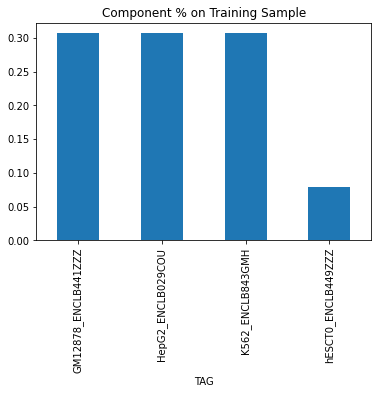

<ipython-input-15-cfb66101adbf>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_shuffled['sequence'] = df_train_shuffled['sequence'].apply(lambda x : ''.join(random.sample(list(x), len(x)))  )


Generating Fasta and Motis: train
------------------------------
Generating Motifs (all seqs)
Computing Motifs....
2023-01-17 12:07:25,712 - INFO - No config found.
2023-01-17 12:07:25,712 - INFO - Creating new config.
2023-01-17 12:07:25,714 - INFO - Using included version of MDmodule.
2023-01-17 12:07:25,731 - WARNING - MEME not found. To include it you will have to install it.
2023-01-17 12:07:25,745 - WARNING - MEMEW not found. To include it you will have to install it.
2023-01-17 12:07:25,762 - WARNING - DREME not found. To include it you will have to install it.
2023-01-17 12:07:25,778 - WARNING - Weeder not found. To include it you will have to install it.
2023-01-17 12:07:25,792 - WARNING - GADEM not found. To include it you will have to install it.
2023-01-17 12:07:25,792 - INFO - Using included version of MotifSampler.
2023-01-17 12:07:25,805 - WARNING - Trawler not found. To include it you will have to install it.
2023-01-17 12:07:25,805 - INFO - Using included version of Im

In [23]:
# Lucas filtered file (avaliable on discord)
# https://drive.google.com/drive/folders/1dBeZIdJZQqaZUzCBVrz_Z2fAV9ePsw7h?usp=sharing


import pickle

raw_data = DataLoading(
    "selected_K562_hESCT0_HepG2_GM12878_12k_sequences_per_group.txt",
    subset_components=['GM12878_ENCLB441ZZZ', 'hESCT0_ENCLB449ZZZ', 'K562_ENCLB843GMH', 'HepG2_ENCLB029COU'],
)  # , limit_total_sequences = 1000)
preprocessed_data = DataPreprocessing(
    raw_data.df_train_raw_grouped,
    raw_data.df_test_raw_grouped,
    raw_data.df_shuffled_raw_grouped,
    subset_components=['GM12878_ENCLB441ZZZ', 'hESCT0_ENCLB449ZZZ', 'K562_ENCLB843GMH', 'HepG2_ENCLB029COU'],
    sample_number=raw_data.sample_number,
)

# Stable Diffusion architecture

This chapter is divided into following sub-chapters:


1.   Sampling functions
2.   Utility functions for UNET
3.   Bit diffusion UNET

The main components of UNET have been taken from this implementation here: https://github.com/lucidrains/bit-diffusion

The main differences are:


*   No Self-Conditioning
*   Diffusion conditioned on components.
*   Substantially different forward pass
*   Conditioned Attention block
*   Classifier-Free Diffusion Guidance





# Classifier-Free Diffusion Guidance

Its idea stemming from https://openreview.net/pdf?id=qw8AKxfYbI

But first of all what is **guidance** (for **conditional** diffusion models)?

TL;DR Following the Bayes Rule we can express conditional distribution as such.

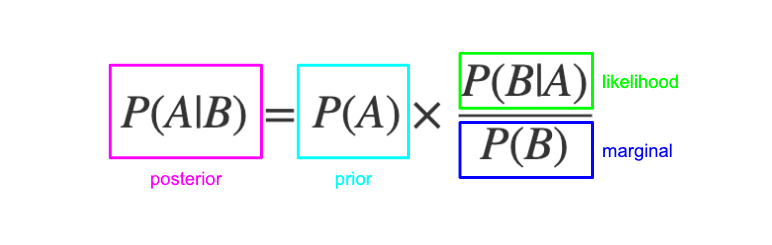

Now to estimate the marginal term we  we can use classifiers (which have their problems) OR we can proceed classifier free, where we will increase our samply efficiency (since we have conditioned on additional information) and we can do it efficiently. Read more [here](https://benanne.github.io/2022/05/26/guidance.html).

Classifier-Free Diffusion Guidance was developed to achieve trade off between sample quality and diversity similar to that obtained using classifier guidance. This approach happens post training of conditional diffusion models. (See training loop below and sample function)

Simple idea behind it is: "*We show that guidance (of the generative model) can be performed by a pure generative
model without such a classifier: we jointly train a conditional and an unconditional
diffusion model, and find that it is possible to combine the resulting conditional
and unconditional scores to attain the afromentioned  trade-off between sample quality and diversity
similar to that obtained using classifier guidance.*"


And this is exactly what the following block of code is for, we will sample efficiently from guided/conditioned stable diffusion:

In [24]:
# Scheduler


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def linear_beta_schedule(timesteps, beta_end=0.005):
    beta_start = 0.0001

    return torch.linspace(beta_start, beta_end, timesteps)


def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2


def sigmoid_beta_schedule(timesteps):
    beta_start = 0.001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


# define beta schedule
betas = linear_beta_schedule(timesteps=TIMESTEPS, beta_end=0.2)
# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
# sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


# Conditioned (improved) sampling


@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    # print (x.shape, 'x_shape')
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, time=t) / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def p_sample_guided(model, x, classes, t, t_index, context_mask, cond_weight=0.0):
    # adapted from: https://openreview.net/pdf?id=qw8AKxfYbI
    # print (classes[0])
    batch_size = x.shape[0]
    # double to do guidance with
    t_double = t.repeat(2)
    x_double = x.repeat(2, 1, 1, 1)
    betas_t = extract(betas, t_double, x_double.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t_double, x_double.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t_double, x_double.shape)

    # classifier free sampling interpolates between guided and non guided using `cond_weight`
    classes_masked = classes * context_mask
    classes_masked = classes_masked.type(torch.long)
    # print ('class masked', classes_masked)
    preds = model(x_double, time=t_double, classes=classes_masked)
    eps1 = (1 + cond_weight) * preds[:batch_size]
    eps2 = cond_weight * preds[batch_size:]
    x_t = eps1 - eps2

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t[:batch_size] * (
        x - betas_t[:batch_size] * x_t / sqrt_one_minus_alphas_cumprod_t[:batch_size]
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, classes, shape, cond_weight):
    device = next(model.parameters()).device
    b = shape[0]
    print(b)
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    if classes is not None:
        n_sample = classes.shape[0]
        context_mask = torch.ones_like(classes).to(device)
        # make 0 index unconditional
        # double the batch
        classes = classes.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 0.0  # makes second half of batch context free
        sampling_fn = partial(p_sample_guided, classes=classes, cond_weight=cond_weight, context_mask=context_mask)
    else:
        sampling_fn = partial(p_sample)

    for i in tqdm(reversed(range(0, TIMESTEPS)), desc='sampling loop time step', total=TIMESTEPS):
        img = sampling_fn(model, x=img, t=torch.full((b,), i, device=device, dtype=torch.long), t_index=i)
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample(model, image_size, classes=None, batch_size=16, channels=3, cond_weight=0):
    return p_sample_loop(model, classes=classes, shape=(batch_size, channels, 4, image_size), cond_weight=cond_weight)

### Loss function

In [25]:
def q_sample(x_start, t, noise=None):
    """
    Forward pass with noise.
    """
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


def p_losses(denoise_model, x_start, t, classes, noise=None, loss_type="l1", p_uncond=0.1):
    """
    Calculate the loss conditioned and noise injected.
    """
    device = x_start.device
    if noise is None:
        noise = torch.randn_like(x_start)  #  gauss noise
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)  # this is the auto generated noise given t and Noise

    context_mask = torch.bernoulli(torch.zeros(classes.shape[0]) + (1 - p_uncond)).to(device)

    # mask for unconditinal guidance
    classes = classes * context_mask
    classes = classes.type(torch.long)
    predicted_noise = denoise_model(x_noisy, t, classes)
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

# Stable Diffusion architecture

This part of the code has been adapted from https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py and for the paper
[*Analog Bits: Generating Discrete Data
using Diffusion Models with Self-Conditioning*](https://arxiv.org/pdf/2208.04202.pdf)

The core changes are indicated with comment 

"*# Additional code to the https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py*"

In [26]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def cycle(dl):
    while True:
        for data in dl:
            yield data


def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


def convert_image_to(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image


def l2norm(t):
    return F.normalize(t, dim=-1)


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


# Building blocks of UNET


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(dim, default(dim_out, dim), 3, padding=1)
    )


def Downsample(dim, dim_out=None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)


class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) * (var + eps).rsqrt() * self.g


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


# Building blocks of UNET, positional embeds


class LearnedSinusoidalPosEmb(nn.Module):
    """following @crowsonkb 's lead with learned sinusoidal pos emb"""

    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim=-1)
        fouriered = torch.cat((x, fouriered), dim=-1)
        return fouriered


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [nn.Linear(input_dim, emb_dim), nn.GELU(), nn.Linear(emb_dim, emb_dim)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# Building blocks of UNET, building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


# Building blocks of UNET, residual part


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2)) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)


# Additional code to the https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py


class ResnetBlockClassConditioned(ResnetBlock):
    def __init__(self, dim, dim_out, *, num_classes, class_embed_dim, time_emb_dim=None, groups=8):
        super().__init__(dim=dim + class_embed_dim, dim_out=dim_out, time_emb_dim=time_emb_dim, groups=groups)
        self.class_mlp = EmbedFC(num_classes, class_embed_dim)

    def forward(self, x, time_emb=None, c=None):
        emb_c = self.class_mlp(c)
        emb_c = emb_c.view(*emb_c.shape, 1, 1)
        emb_c = emb_c.expand(-1, -1, x.shape[-2], x.shape[-1])
        x = torch.cat([x, emb_c], axis=1)

        return super().forward(x, time_emb)


# Building blocks of UNET, attention part


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), LayerNorm(dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads), qkv)

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h=self.heads, x=h, y=w)
        return self.to_out(out)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32, scale=10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads), qkv)

        q, k = map(l2norm, (q, k))

        sim = einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim=-1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)
        return self.to_out(out)


# Core part of UNET


class Unet(nn.Module):
    """
    Refer to the main paper for the architecture details https://arxiv.org/pdf/2208.04202.pdf
    """

    def __init__(
        self,
        dim,
        init_dim=IMAGE_SIZE,
        dim_mults=(1, 2, 4),
        channels=CHANNELS,
        resnet_block_groups=8,
        learned_sinusoidal_dim=18,
        num_classes=10,
        class_embed_dim=3,
    ):
        super().__init__()

        self.channels = channels
        # if you want to do self conditioning uncomment this
        # input_channels = channels * 2
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, (7, 7), padding=3)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        time_dim = dim * 4

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        fourier_dim = learned_sinusoidal_dim + 1

        self.time_mlp = nn.Sequential(
            sinu_pos_emb, nn.Linear(fourier_dim, time_dim), nn.GELU(), nn.Linear(time_dim, time_dim)
        )

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, 1, 1)
        print('final', dim, channels, self.final_conv)

    # Additional code to the https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py mostly in forward method.

    def forward(self, x, time, classes, x_self_cond=None):
        x = self.init_conv(x)
        r = x.clone()

        t_start = self.time_mlp(time)
        t_mid = t_start.clone()
        t_end = t_start.clone()

        if classes is not None:
            t_start += self.label_emb(classes)
            t_mid += self.label_emb(classes)
            t_end += self.label_emb(classes)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t_start)
            h.append(x)

            x = block2(x, t_start)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t_mid)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t_mid)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t_mid)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t_mid)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)
        x = self.final_res_block(x, t_end)

        x = self.final_conv(x)
        return x

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
# model = Unet(
#     dim = IMAGE_SIZE,
#         channels = CHANNELS,
#     dim_mults = (1,2,4),
#     resnet_block_groups = RESNET_BLOCK_GROUPS,
#     num_classes=TOTAL_CLASS_NUMBER).cuda()

model = Unet(
    dim=IMAGE_SIZE,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
)


model.to(device)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

live_kl = PlotLosses(groups={'KL': ['train', 'test', 'shuffle'], 'DiffusionLoss': ['loss']})
train_kl, test_kl, shuffle_kl = 1, 1, 1

final 200 1 Conv2d(200, 1, kernel_size=(1, 1), stride=(1, 1))


# Stable Diffusion training metric functions and evaluation

We need a Pytorch like interface:

In [29]:
class SequenceDataset(Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, seqs, c, transform=None):
        'Initialization'
        self.seqs = seqs
        self.c = c
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.seqs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.seqs[index]

        x = self.transform(image)

        y = self.c[index]

        return x, y

We extract the morids and counts of motifs per component from the preprocessed data object:

In [30]:
df_results_seq_guime_count_train = preprocessed_data.train['motifs']
df_results_seq_guime_count_test = preprocessed_data.test['motifs']
df_results_seq_guime_count_shuffle = preprocessed_data.train_shuffle['motifs']


final_comp_values_train = preprocessed_data.train['motifs_per_components_dict']
final_comp_values_test = preprocessed_data.test['motifs_per_components_dict']
final_comp_values_shuffle = preprocessed_data.train_shuffle['motifs_per_components_dict']

raw_dataset = preprocessed_data.train['dataset']
# cell_components = raw_dataset.sort_values('component')['component'].unique().tolist()
# lucas change
cell_components = (
    raw_dataset.sort_values('TAG')['TAG'].unique().tolist()
)  # I need to add this function inside the dataloader

We take the raw sequence and we group it by components before feeding it into the model:

In [31]:
X_train = np.array(
    [one_hot_encode(x, NUCLEOTIDES, 200) for x in tqdm_notebook(raw_dataset['sequence']) if 'N' not in x]
)
X_train = np.array([x.T.tolist() for x in X_train])
X_train[X_train == 0] = -1
# conditional training init


# LUCAS change
# creating a number for each cell type
# probably we can use the new Zach encoder to fix it?

conditional_tag_to_numeric = {
    x: n + 1 for n, x in enumerate(raw_dataset['TAG'].unique())
}  # check if this is changing order during different executions
conditional_numeric_to_tag = {
    n + 1: x for n, x in enumerate(raw_dataset['TAG'].unique())
}  # check if this is changing order

cell_types = sorted(list(conditional_numeric_to_tag.keys()))

# cell_types = sorted(list(raw_dataset['TAG'].unique()))
x_train_cell_type = torch.from_numpy(raw_dataset["TAG"].apply(lambda x: conditional_tag_to_numeric[x]).to_numpy())
# x_train_cell_type = torch.from_numpy(raw_dataset["TAG"].to_numpy())

<ipython-input-31-63e889d75671>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  X_train = np.array([one_hot_encode(x, NUCLEOTIDES, 200) for x in tqdm_notebook(raw_dataset['sequence']) if 'N' not in x ])


  0%|          | 0/31969 [00:00<?, ?it/s]

Then we initialize the torch compatible interface:

In [32]:
tf = T.Compose([T.ToTensor()])
seq_dataset = SequenceDataset(seqs=X_train, c=x_train_cell_type, transform=tf)
train_dl = DataLoader(seq_dataset, BATCH_SIZE, shuffle=True)  # , num_workers=3, pin_memory=True)

Next we define a function that will sample from our trained stable diffusion the DNS samples and we are going to use the occurances of the sampled examples to evaluate our metric across train,test and shuffled examples

In [33]:
def sampling_to_metric(number_of_samples=20, specific_group=False, group_number=None, cond_weight_to_metric=0):
    """
    This function encapsulates the logic of sampling from the trained model in order to generate counts of the motifs.
    The reasoning is that we are interested only in calculating the evaluation metric
    for the count of occurances and not the nucleic acids themselves.
    """
    final_sequences = []
    for n_a in tqdm_notebook(range(number_of_samples)):
        sample_bs = 10
        if specific_group:
            sampled = torch.from_numpy(np.array([group_number] * sample_bs))
            print('specific')
        else:
            sampled = torch.from_numpy(np.random.choice(cell_types, sample_bs))

        random_classes = sampled.float().cuda()
        sampled_images = sample(
            model,
            classes=random_classes,
            image_size=IMAGE_SIZE,
            batch_size=sample_bs,
            channels=1,
            cond_weight=cond_weight_to_metric,
        )
        for n_b, x in enumerate(sampled_images[-1]):
            seq_final = f'>seq_test_{n_a}_{n_b}\n' + ''.join(
                [NUCLEOTIDES[s] for s in np.argmax(x.reshape(4, 200), axis=0)]
            )
            final_sequences.append(seq_final)

    save_motifs_syn = open('synthetic_motifs.fasta', 'w')

    save_motifs_syn.write('\n'.join(final_sequences))
    save_motifs_syn.close()
    # Scan for motifs
    !gimme scan synthetic_motifs.fasta -p   JASPAR2020_vertebrates -g hg38 > syn_results_motifs.bed
    df_results_syn = pd.read_csv('syn_results_motifs.bed', sep='\t', skiprows=5, header=None)
    df_results_syn['motifs'] = df_results_syn[8].apply(lambda x: x.split('motif_name "')[1].split('"')[0])
    df_results_syn[0] = df_results_syn[0].apply(lambda x: '_'.join(x.split('_')[:-1]))
    df_motifs_count_syn = df_results_syn[[0, 'motifs']].drop_duplicates().groupby('motifs').count()
    plt.rcParams["figure.figsize"] = (30, 2)
    df_motifs_count_syn.sort_values(0, ascending=False).head(50)[0].plot.bar()
    plt.show()

    return df_motifs_count_syn

In [34]:
gc.collect()
torch.cuda.empty_cache()

Here we train the model, and after certain epochs we compare the loss and the wether the metric of choices actually decreases across the train test and shuffle datasets.

In [35]:
from scipy.misc import derivative

In [36]:
import math
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-37-dc4de8801332>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
<ipython-input-37-dc4de8801332>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])


 Epoch 0 Loss: 37.925251971930265
saving
started
2
first



sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 23.23it/s]


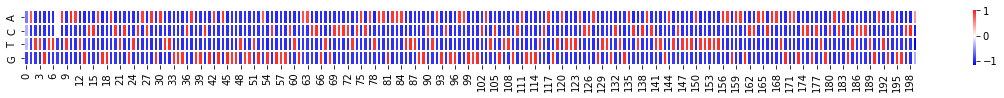

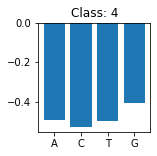

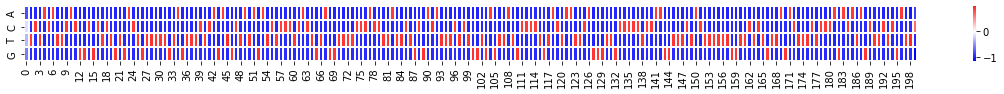

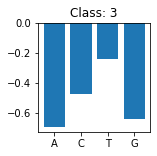

<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.76it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.59it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.53it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.32it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.91it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.32it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.87it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.88it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.63it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.90it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.60it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.24it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.13it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.76it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.53it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.21it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.21it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.02it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.76it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.36it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.22it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.23it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:06,  5.95it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:06,  5.90it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:02

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.07it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.73it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.87it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.76it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.61it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:08,  6.03it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:08,  5.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.10it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:07,  6.00it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:07,  5.73it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:01<00:07,  5.65it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:07,  5.83it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:07,  5.95it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:07,  5.73it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  5.89it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:06,  5.96it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:02<00:06,  5.96it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:02

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.16it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:08,  5.82it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:08,  5.61it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:07,  5.85it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:07,  5.93it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:01<00:07,  5.70it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:07,  5.71it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:07,  5.44it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:07,  5.69it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  5.94it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:06,  6.10it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:02<00:06,  6.20it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:02

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.90it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.75it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.72it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.32it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.44it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.91it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.83it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.00it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.58it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

scanning: 100% 200/200 [00:06<00:00, 32.78 sequences/s]


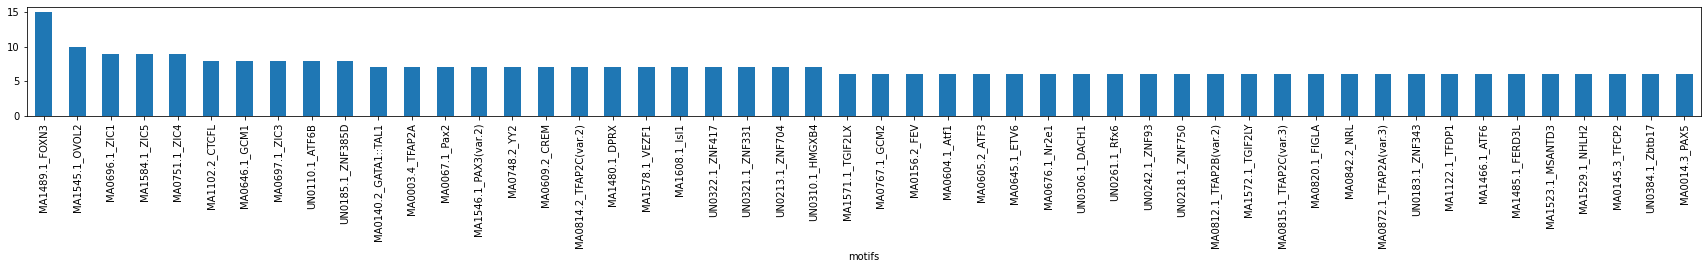

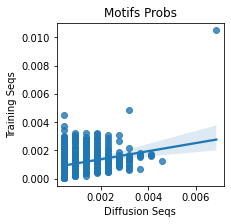

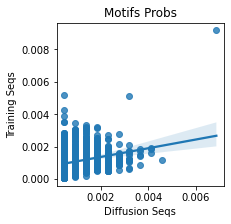

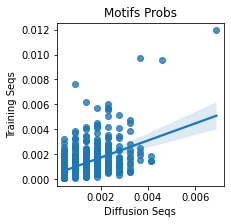

 10%|█         | 1/10 [16:06<2:25:01, 966.79s/it]

KL_TRAIN 0.28029518365390427 KL
KL_TEST 0.28125298462404147 KL
KL_SHUFFLE 0.2530101131668659 KL
train 0.28029518365390427
test_kl 0.28125298462404147
shuffle_kl 0.2530101131668659
total epoch loss tensor(37.9253, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-37-dc4de8801332>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
<ipython-input-37-dc4de8801332>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])


saving
started
2
first



sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 23.24it/s]


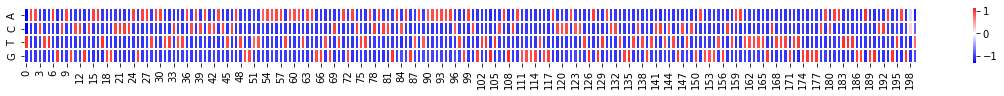

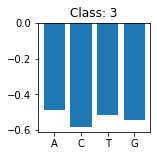

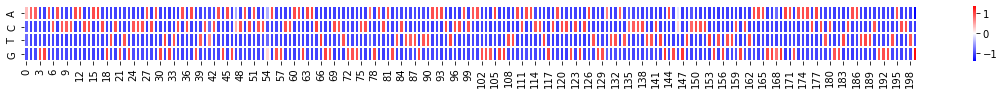

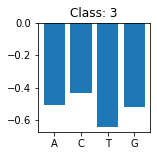

<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.45it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.96it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.85it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.33it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.82it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.65it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.66it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:05,  6.67it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.62it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:07,  6.56it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.29it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.06it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.54it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  5.99it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:07,  6.13it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:07,  6.09it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:07,  6.17it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.31it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.39it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.41it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.44it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:06,  6.48it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:02

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.72it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.63it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.22it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.75it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.94it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.75it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.51it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.50it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.23it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.24it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.65it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.24it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.88it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.77it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.17it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.18it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.27it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.11it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.08it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.52it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.50it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.49it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.17it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

scanning: 100% 200/200 [00:06<00:00, 33.22 sequences/s]


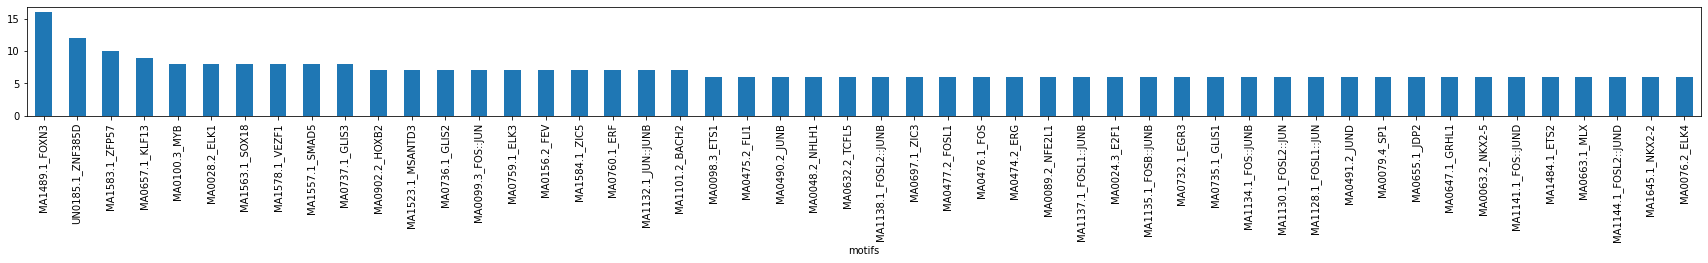

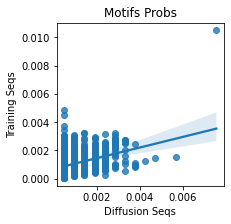

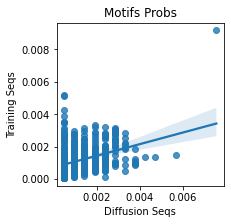

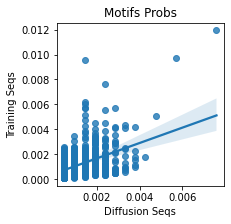

 20%|██        | 2/10 [32:09<2:08:37, 964.67s/it]

KL_TRAIN 0.25131722230295017 KL
KL_TEST 0.254584068575037 KL
KL_SHUFFLE 0.2929489920954701 KL
train 0.25131722230295017
test_kl 0.254584068575037
shuffle_kl 0.2929489920954701
total epoch loss tensor(44.0119, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-37-dc4de8801332>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
<ipython-input-37-dc4de8801332>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])


saving
started
2
first



sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 23.33it/s]


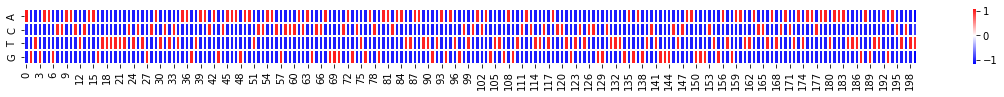

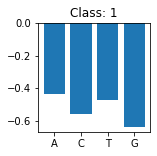

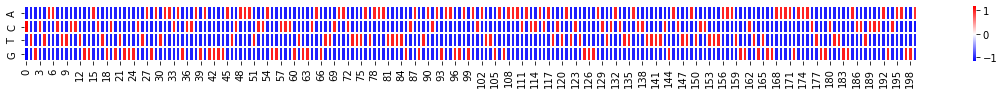

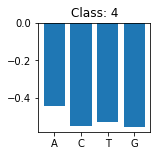

<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.13it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.78it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.73it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.73it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.55it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:07,  6.56it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.52it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.73it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.63it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.24it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.53it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.54it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.09it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.21it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.82it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.75it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.71it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.32it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.88it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.50it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.50it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.51it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.02it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.75it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.60it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.37it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.75it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.06it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.76it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.45it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.45it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.46it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.49it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.47it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:06,  6.49it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.24it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.82it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.23it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.89it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.15it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.75it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.65it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.65it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.13it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.29it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.73it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.64it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:07,  6.56it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.50it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.05it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.39it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.87it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.50it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.16it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.77it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.38it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.87it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.75it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

scanning: 100% 200/200 [00:05<00:00, 34.06 sequences/s]


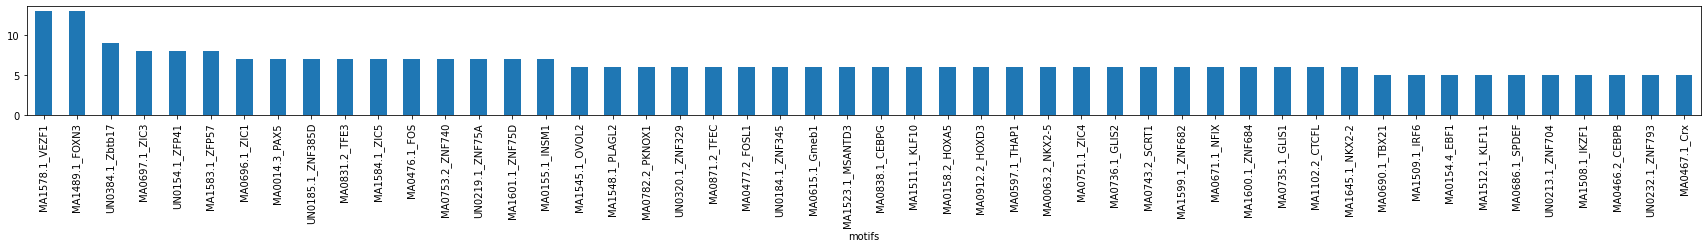

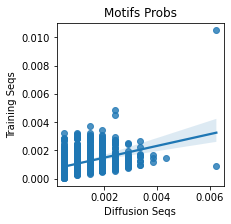

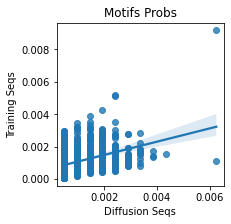

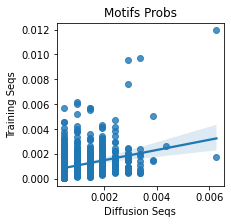

 30%|███       | 3/10 [48:13<1:52:27, 963.94s/it]

KL_TRAIN 0.22289779144511124 KL
KL_TEST 0.22446527152930118 KL
KL_SHUFFLE 0.3479551605813809 KL
train 0.22289779144511124
test_kl 0.22446527152930118
shuffle_kl 0.3479551605813809
total epoch loss tensor(24.2429, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-37-dc4de8801332>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
<ipython-input-37-dc4de8801332>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])


saving
started
2
first



sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 23.07it/s]


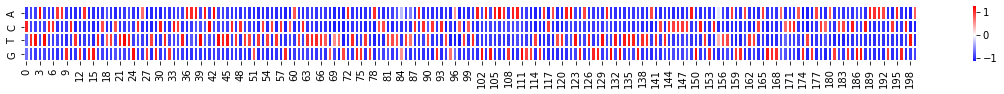

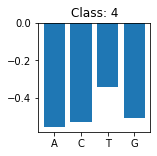

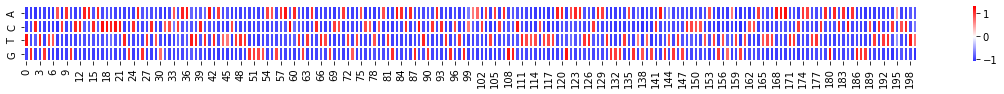

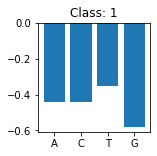

<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.09it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.12it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.80it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.65it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.29it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.25it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.82it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.65it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.08it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.15it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.54it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.51it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.18it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.26it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.82it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.90it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.52it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.23it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.75it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.54it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.05it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.11it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.76it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.25it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.79it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.72it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.23it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.14it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.66it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.08it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.77it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.33it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.65it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.31it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.87it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.03it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.72it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.54it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

scanning: 100% 200/200 [00:05<00:00, 34.60 sequences/s]


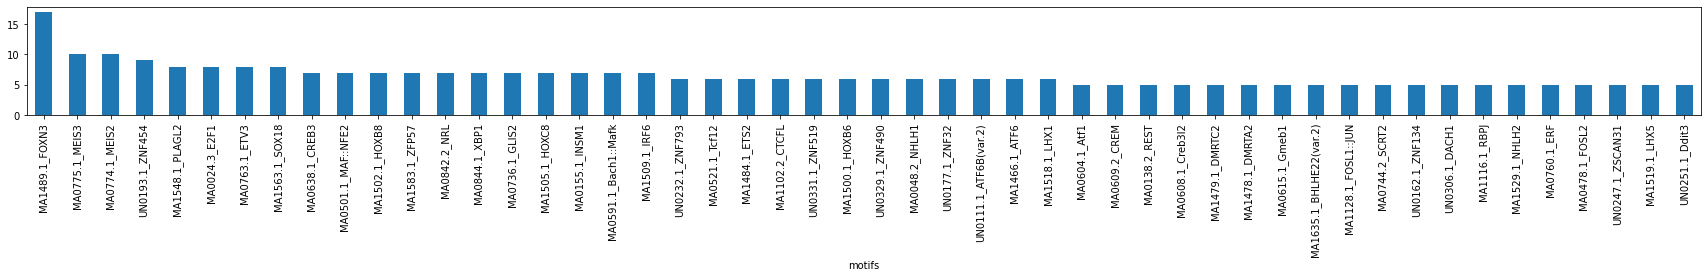

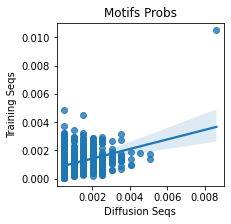

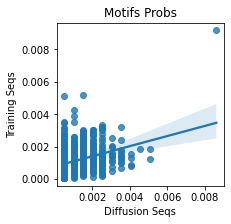

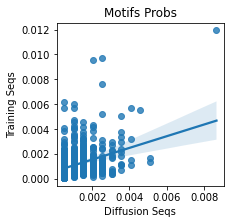

 40%|████      | 4/10 [1:04:15<1:36:20, 963.38s/it]

KL_TRAIN 0.2692746228993991 KL
KL_TEST 0.2834433602929204 KL
KL_SHUFFLE 0.3324074575581883 KL
train 0.2692746228993991
test_kl 0.2834433602929204
shuffle_kl 0.3324074575581883
total epoch loss tensor(38.4940, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-37-dc4de8801332>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
<ipython-input-37-dc4de8801332>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])


saving
started
2
first



sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 22.97it/s]


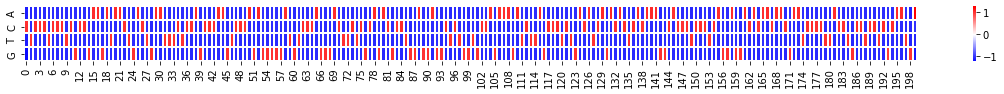

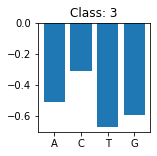

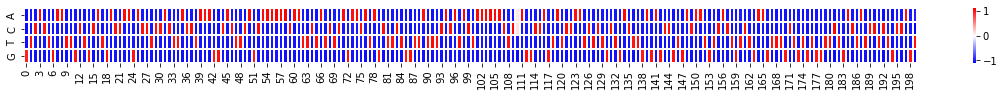

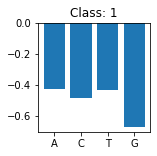

<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.88it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.64it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.51it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.27it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.88it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.26it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.91it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.18it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.97it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.80it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.16it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.72it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.22it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.76it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.64it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.50it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.27it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.89it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.75it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.30it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.87it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.66it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.64it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.62it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:07,  6.54it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.16it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.87it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.50it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.22it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.75it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.30it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.88it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.62it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:07,  6.57it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.65it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:05,  6.67it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.67it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.16it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.78it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.74it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.41it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

scanning: 100% 200/200 [00:05<00:00, 34.21 sequences/s]


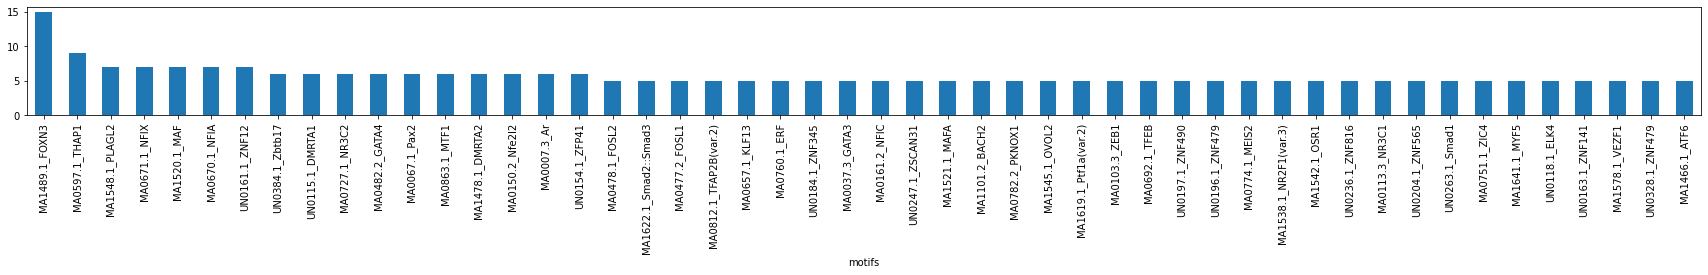

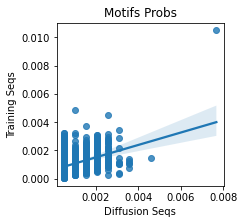

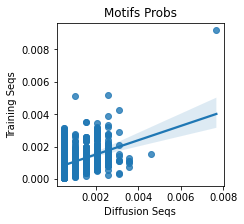

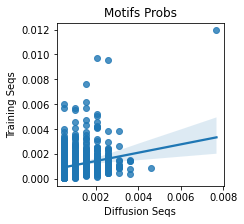

 50%|█████     | 5/10 [1:20:22<1:20:23, 964.67s/it]

KL_TRAIN 0.22247740511794417 KL
KL_TEST 0.22571473033047562 KL
KL_SHUFFLE 0.38563512688939133 KL
train 0.22247740511794417
test_kl 0.22571473033047562
shuffle_kl 0.38563512688939133
total epoch loss tensor(29.6770, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-37-dc4de8801332>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
<ipython-input-37-dc4de8801332>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])


 Epoch 5 Loss: 22.172443540766835
saving
started
2
first



sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 22.90it/s]


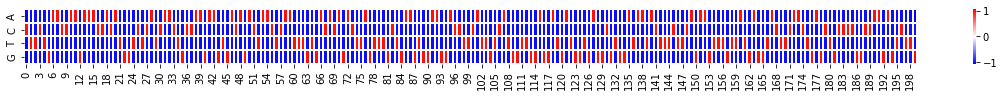

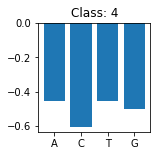

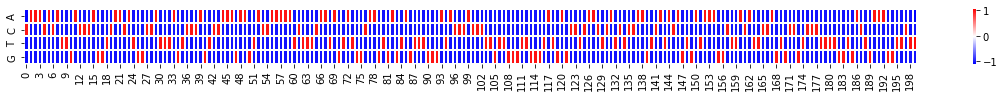

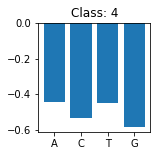

<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.16it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.91it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.77it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.71it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.28it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.88it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.95it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.17it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.73it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.22it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.64it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.10it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.31it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.94it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.61it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.27it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.01it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.75it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.15it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:07,  6.56it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.18it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.91it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.51it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.22it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.03it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.49it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.51it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.49it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.15it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.18it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.31it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

scanning: 100% 200/200 [00:05<00:00, 34.29 sequences/s]


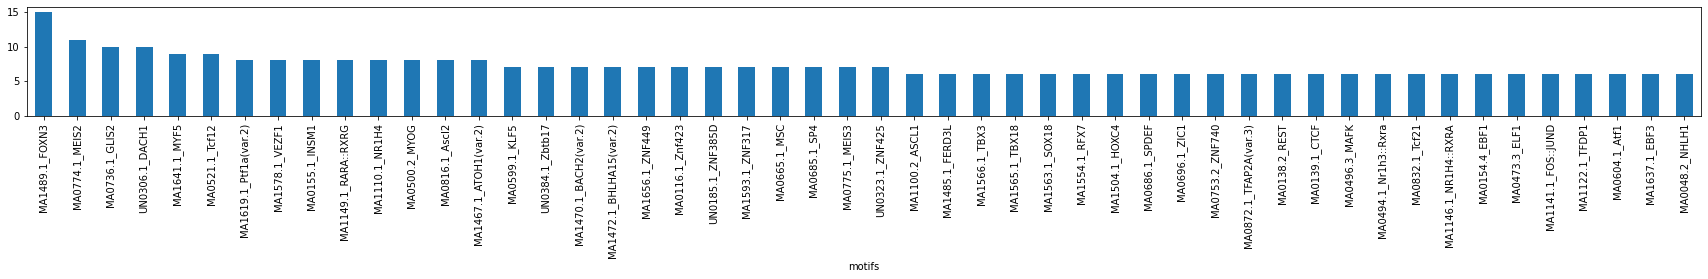

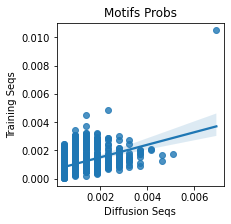

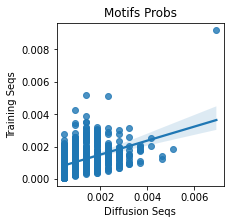

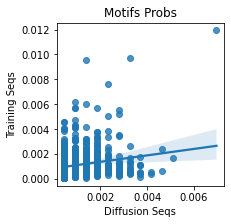

 60%|██████    | 6/10 [1:36:29<1:04:21, 965.39s/it]

KL_TRAIN 0.2092595438481153 KL
KL_TEST 0.21456132448299833 KL
KL_SHUFFLE 0.42283139696259475 KL
train 0.2092595438481153
test_kl 0.21456132448299833
shuffle_kl 0.42283139696259475
total epoch loss tensor(22.1725, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-37-dc4de8801332>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
<ipython-input-37-dc4de8801332>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])


saving
started
2
first



sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 22.47it/s]


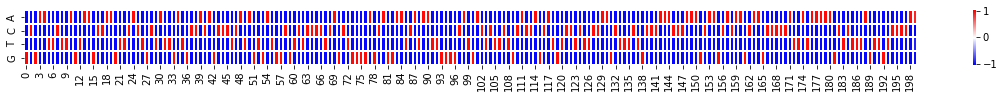

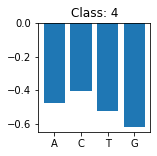

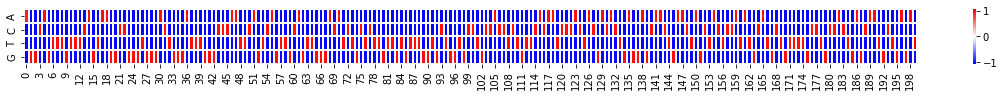

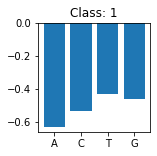

<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.01it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.75it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.11it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.30it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.22it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.82it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.77it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.54it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.72it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.61it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.13it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.77it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.17it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.16it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.75it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.31it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.51it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.09it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.64it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.98it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.73it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.21it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.65it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.10it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.80it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.18it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.80it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.49it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.41it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.59it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.58it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.91it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.76it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.43it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.89it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.23it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

scanning: 100% 200/200 [00:05<00:00, 34.11 sequences/s]


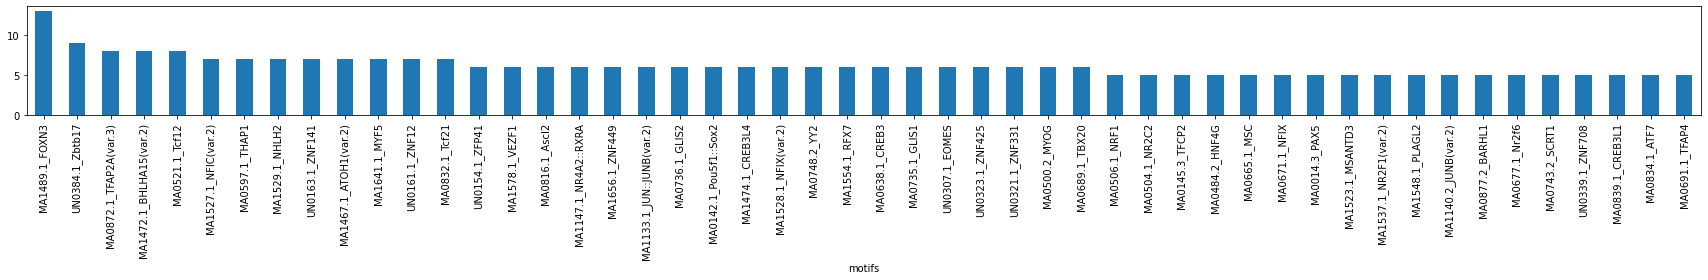

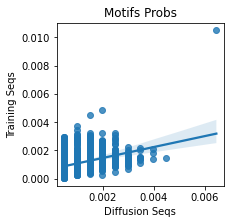

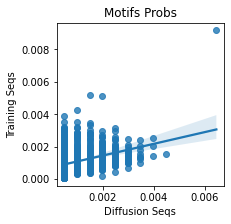

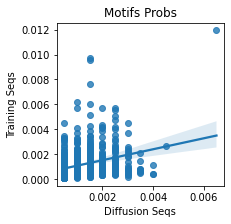

 70%|███████   | 7/10 [1:52:36<48:18, 966.05s/it]  

KL_TRAIN 0.22935203453257857 KL
KL_TEST 0.23179212745229646 KL
KL_SHUFFLE 0.34419033369545404 KL
train 0.22935203453257857
test_kl 0.23179212745229646
shuffle_kl 0.34419033369545404
total epoch loss tensor(32.6080, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-37-dc4de8801332>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
<ipython-input-37-dc4de8801332>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])


saving
started
2
first



sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 22.53it/s]


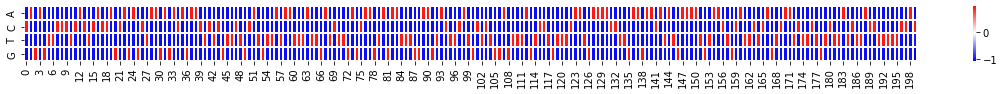

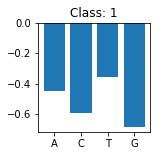

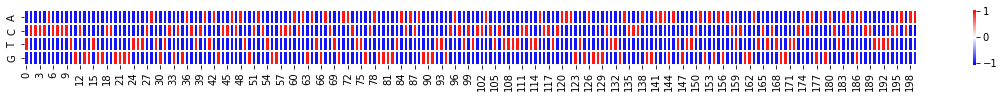

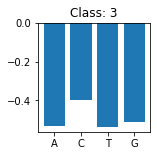

<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.34it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.15it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.82it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.52it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.15it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.22it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.06it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.23it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.50it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.47it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.51it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.91it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.72it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.63it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.53it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.93it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.11it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.80it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.75it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.22it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.69it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.96it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.75it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.61it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.22it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.77it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.71it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.69it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.48it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.29it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.92it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.79it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.51it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.76it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.26it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.92it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.25it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.73it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.99it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.72it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

scanning: 100% 200/200 [00:05<00:00, 34.88 sequences/s]


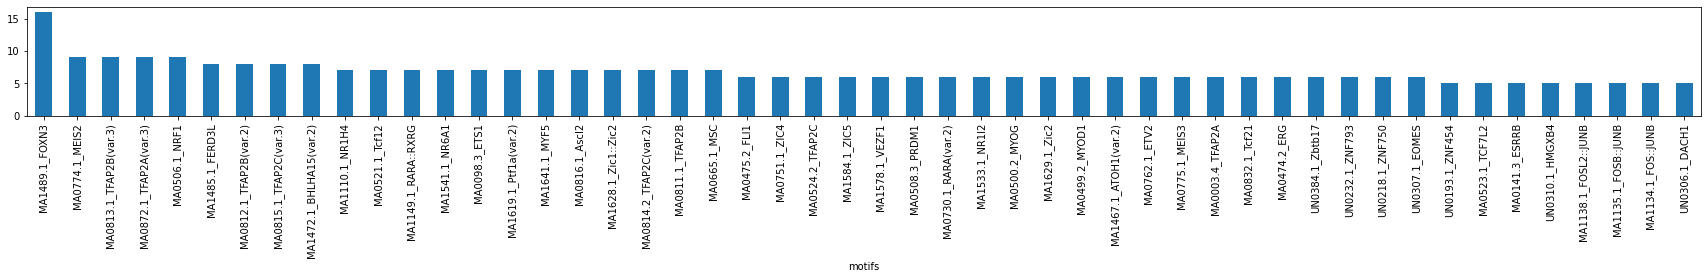

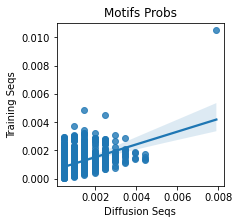

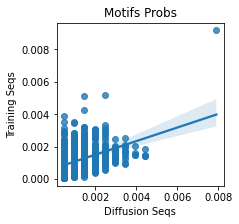

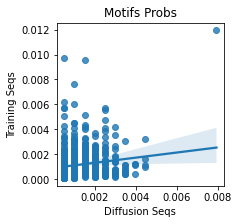

 80%|████████  | 8/10 [2:08:43<32:12, 966.30s/it]

KL_TRAIN 0.20964048150614129 KL
KL_TEST 0.22134351438850208 KL
KL_SHUFFLE 0.45404953156383226 KL
train 0.20964048150614129
test_kl 0.22134351438850208
shuffle_kl 0.45404953156383226
total epoch loss tensor(32.9833, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-37-dc4de8801332>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
<ipython-input-37-dc4de8801332>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])


saving
started
2
first



sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 22.69it/s]


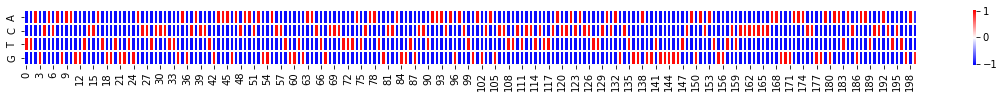

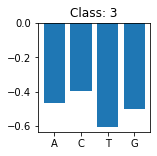

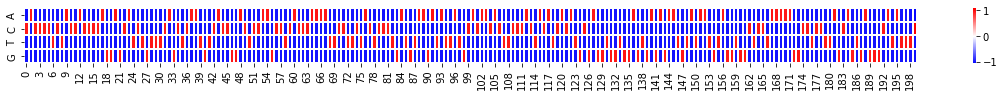

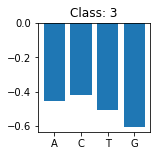

<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.14it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.88it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.78it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.71it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.94it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.12it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.65it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.86it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.67it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.04it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.53it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.82it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.72it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.13it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.55it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.52it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.50it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.51it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.18it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.65it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.88it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.08it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.52it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.25it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.81it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.76it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.53it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.22it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.80it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.57it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.09it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.63it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.15it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.62it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.08it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.83it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.54it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.75it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.66it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.63it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.65it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.01it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.73it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.65it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.29it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.77it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.16it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.86it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

scanning: 100% 200/200 [00:05<00:00, 34.60 sequences/s]


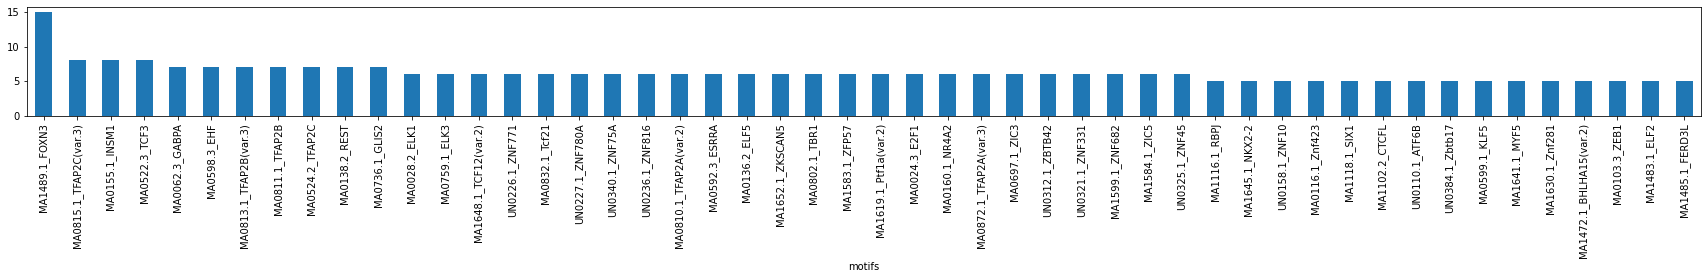

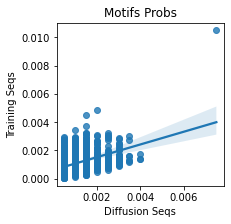

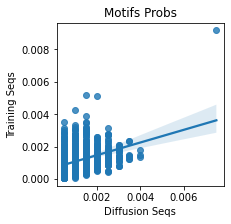

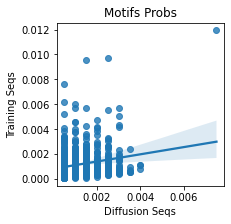

 90%|█████████ | 9/10 [2:24:50<16:06, 966.55s/it]

KL_TRAIN 0.21594127717898592 KL
KL_TEST 0.2301444010510485 KL
KL_SHUFFLE 0.41014566348727755 KL
train 0.21594127717898592
test_kl 0.2301444010510485
shuffle_kl 0.41014566348727755
total epoch loss tensor(32.5263, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-37-dc4de8801332>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
<ipython-input-37-dc4de8801332>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])


saving
started
2
first



sampling loop time step: 100%|██████████| 50/50 [00:02<00:00, 22.59it/s]


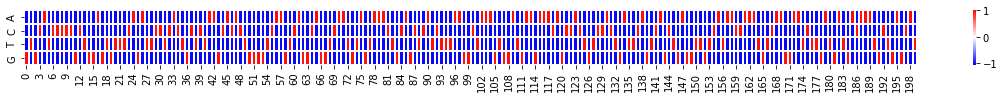

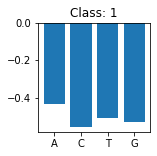

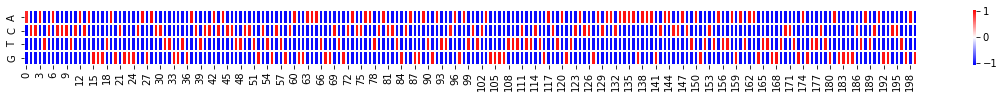

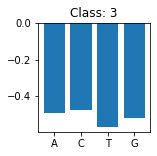

<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.42it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.98it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.80it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.72it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.24it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.92it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.60it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.01it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.55it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.57it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.23it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.88it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.65it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.64it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.21it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.87it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.77it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.72it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.21it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.90it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.82it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.74it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.62it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.94it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.54it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.55it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.90it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.72it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.64it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.59it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.33it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.85it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.77it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.34it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.92it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.77it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.73it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.29it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:06,  6.87it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.77it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.08it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.80it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.74it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.70it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.57it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.56it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.99it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.79it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:06,  6.73it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.72it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.66it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.65it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.10it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.76it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.15it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.77it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.56it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.58it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.58it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:07,  6.84it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.70it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.68it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.64it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.61it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.58it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.59it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.14it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.80it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.71it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.66it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.65it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.64it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.60it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.59it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.60it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

started
10
first




sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   2%|▏         | 1/50 [00:00<00:06,  7.03it/s]

sampling loop time step:   4%|▍         | 2/50 [00:00<00:07,  6.80it/s]

sampling loop time step:   6%|▌         | 3/50 [00:00<00:07,  6.67it/s]

sampling loop time step:   8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

sampling loop time step:  10%|█         | 5/50 [00:00<00:06,  6.62it/s]

sampling loop time step:  12%|█▏        | 6/50 [00:00<00:06,  6.63it/s]

sampling loop time step:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

sampling loop time step:  16%|█▌        | 8/50 [00:01<00:06,  6.63it/s]

sampling loop time step:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s]

sampling loop time step:  20%|██        | 10/50 [00:01<00:06,  6.65it/s]

sampling loop time step:  22%|██▏       | 11/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  24%|██▍       | 12/50 [00:01<00:05,  6.63it/s]

sampling loop time step:  26%|██▌       | 13/50 [00:01

scanning: 100% 200/200 [00:05<00:00, 35.11 sequences/s]


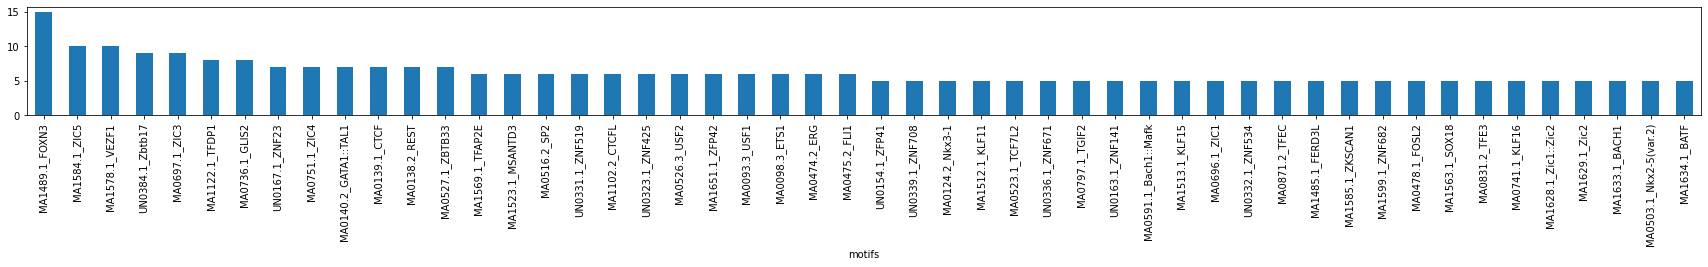

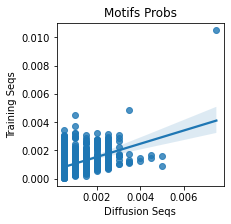

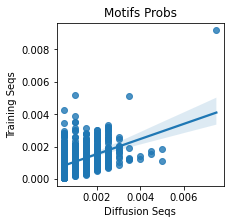

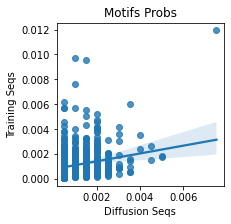

100%|██████████| 10/10 [2:40:57<00:00, 965.74s/it]

KL_TRAIN 0.2004884097295233 KL
KL_TEST 0.20037071555973696 KL
KL_SHUFFLE 0.39079066527456396 KL
train 0.2004884097295233
test_kl 0.20037071555973696
shuffle_kl 0.39079066527456396
total epoch loss tensor(32.9449, device='cuda:0', grad_fn=<AddBackward0>)


In [37]:
ema = EMA(0.995)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

time_warping_rf = RandomForestRegressor()
time_warping_lgb = lgb.LGBMRegressor()
best_lgbm = None

# for epoch in tqdm(range(EPOCHS)):
for epoch in tqdm(range(10)):
    total_loss = 0
    epoch_losses = []
    batch_t = []
    model.train()
    for step, batch in enumerate(train_dl):
        x, y = batch
        x = x.type(torch.float32).to(device)
        y = y.type(torch.long).to(device)
        t = torch.randint(0, TIMESTEPS, (x.shape[0],), device=device).long()  # *np.random.uniform()

        if TIME_WARPING == True and step >= N_STEPS:
            # sort the epoch losses so that one can take the t-s with the biggest losses
            sort_val = np.argsort(epoch_losses)
            sorted_t = [batch_t[i] for i in sort_val]

            # take the t-s for the 5 biggest losses (5 was taken as example, no extensive optimization)
            last_n_t = sorted_t[-5:]
            unnested_last_n_t = [item for sublist in last_n_t for item in sublist]

            # take x.shape[0] number of t-s for the 5 biggest losses
            t_not_random = torch.tensor(np.random.choice(unnested_last_n_t, size=x.shape[0]), device="cpu")
            # pick between t generated above and t_not_random (to increase exploration, and not to get stuck
            # in the same t-s)
            t = np.random.choice([t.cpu().detach(), t_not_random.cpu().detach()])
            t = t.to(device)

        loss = p_losses(model, x, t, y, loss_type="huber")
        total_loss += loss
        epoch_losses.append(loss.item())
        batch_t.append(list(t.cpu().detach().numpy()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.step_ema(ema_model, model)

    if (epoch % EPOCHS_LOSS_SHOW) == 0:
        print(f" Epoch {epoch} Loss:", sum(epoch_losses))

    # save generated images
    if epoch % SAVE_AND_SAMPLE_EVERY == 0:
        model.eval()
        print('saving')
        milestone = step // SAVE_AND_SAMPLE_EVERY
        sample_bs = 2
        # This needs to be fixed to the random
        sampled = torch.from_numpy(np.random.choice(cell_types, sample_bs))
        random_classes = sampled.cuda()

        samples = sample(model, classes=random_classes, image_size=IMAGE_SIZE, batch_size=2, channels=1, cond_weight=1)
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 200))
                pd_seq.index = NUCLEOTIDES
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)

                plt.bar(NUCLEOTIDES, pd_seq.mean(1).T)
                plt.title(f'Class: {class_show}')
                plt.show()
                n_print = n_print + 1

        synt_df = sampling_to_metric(20)
        train_kl = compare_motif_list(synt_df, df_results_seq_guime_count_train)
        test_kl = compare_motif_list(synt_df, df_results_seq_guime_count_test)
        shuffle_kl = compare_motif_list(synt_df, df_results_seq_guime_count_shuffle)
        print('KL_TRAIN', train_kl, 'KL')
        print('KL_TEST', test_kl, 'KL')
        print('KL_SHUFFLE', shuffle_kl, 'KL')
        print('total epoch loss', total_loss)
#         live_kl.update({'train':train_kl, 'test':test_kl , 'shuffle':shuffle_kl , 'loss': loss.item()})
# DO NOTE ONE THING: THE X AXIS IS NOT THE EPOCHS, but epochs*save_and_sample_every
#         live_kl.send()

In [38]:
torch.save(model.state_dict(), "model_dna_diff")

In [42]:
final_comp_values_test[3] = final_comp_values_test.pop('GM12878_ENCLB441ZZZ')
final_comp_values_test[8] = final_comp_values_test.pop('HepG2_ENCLB029COU')
final_comp_values_test[12] = final_comp_values_test.pop('K562_ENCLB843GMH')
final_comp_values_test[15] = final_comp_values_test.pop('hESCT0_ENCLB449ZZZ')

final_comp_values_train[3] = final_comp_values_train.pop('GM12878_ENCLB441ZZZ')
final_comp_values_train[8] = final_comp_values_train.pop('HepG2_ENCLB029COU')
final_comp_values_train[12] = final_comp_values_train.pop('K562_ENCLB843GMH')
final_comp_values_train[15] = final_comp_values_train.pop('hESCT0_ENCLB449ZZZ')

Finally lets compare a heatmap of the (KL) metric between the different components:

# Module metric by component

In [46]:
def kl_comparison_generated_sequences(components_list, dict_targer_components):
    '''
    ex: components_list = [3, 8, 12, 15]
    '''
    final_comp_kl = []
    use_comp_list = components_list
    for r in use_comp_list:
        print(r), 'component'
        comp_array = []
        group_compare = r
        synt_df_cond = sampling_to_metric(20, True, group_compare, cond_weight_to_metric=1)
        for k in use_comp_list:
            v = dict_targer_components[k]
            kl_out = compare_motif_list(synt_df_cond, v)
            print(r, k, kl_out)
            comp_array.append(kl_out)
        final_comp_kl.append(comp_array)
    plt.rcParams["figure.figsize"] = (10, 10)
    df_plot = pd.DataFrame(final_comp_kl)
    df_plot.columns = [CELL_NAMES[x] for x in components_list]
    df_plot.index = df_plot.columns
    sns.heatmap(df_plot, cmap='Blues_r', annot=True, lw=0.1, vmax=1, vmin=0)
    plt.title(f'Kl divergence')
    # plt.xlabel(f'{x_label_plot} Sequences  \n(motifs dist)')
    # plt.ylabel(f'{y_label_plot} \n (motifs dist)')
    return final_comp_kl

In [45]:
print("Tin")

Tin


3


<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.44it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:08<00:00,  6.19it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.39it/s]


scanning: 100% 200/200 [00:05<00:00, 33.77 sequences/s]


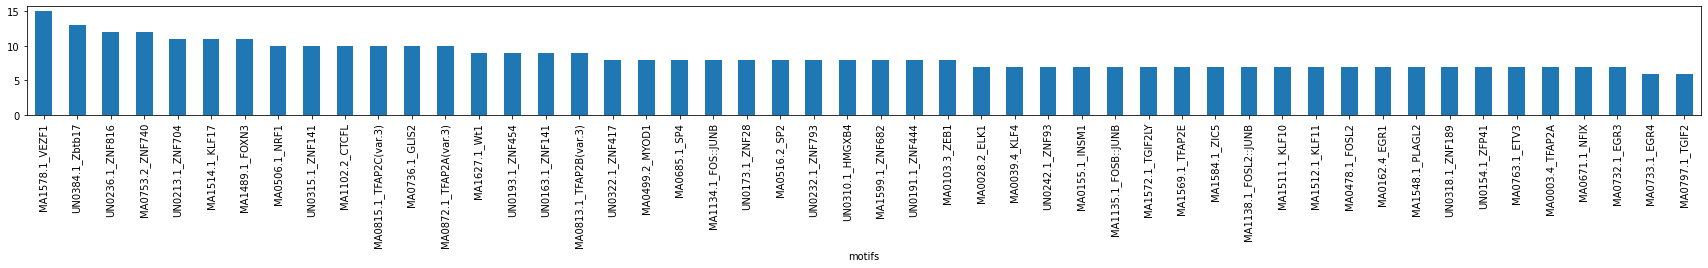

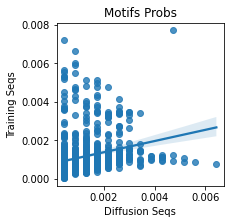

3 3 0.32717853485722875


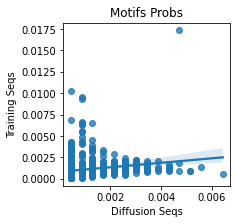

3 8 0.3407078688749804


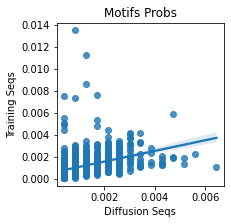

3 12 0.2640496153996249


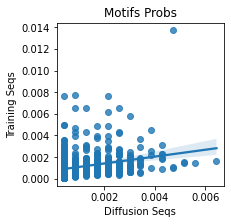

3 15 0.348605040592769
8


<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.60it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.60it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


scanning: 100% 200/200 [00:05<00:00, 34.08 sequences/s]


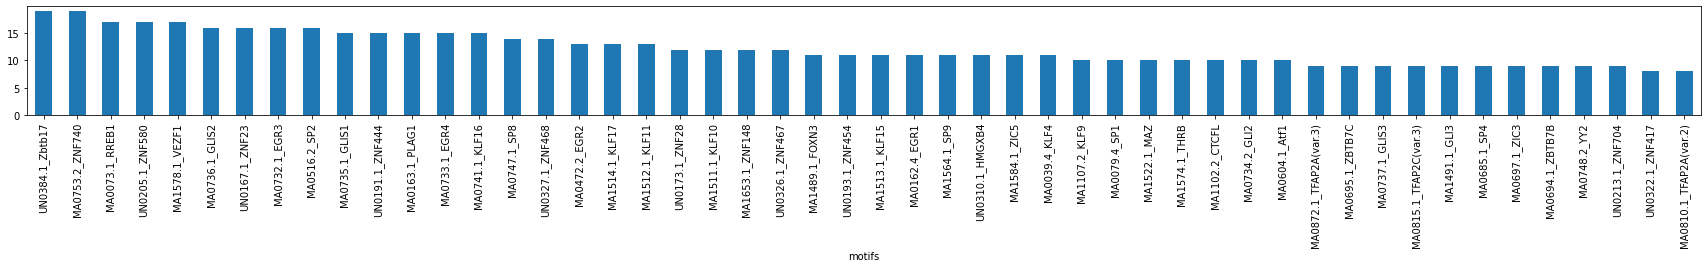

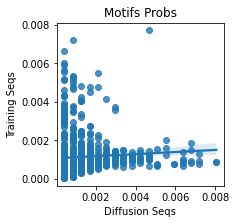

8 3 0.5374790591942631


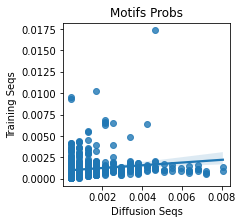

8 8 0.48745596972221883


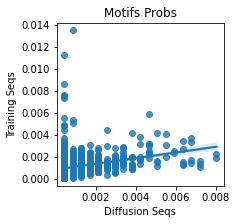

8 12 0.39144754954562344


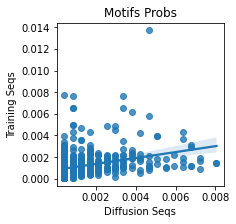

8 15 0.4026627639482774
12


<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.44it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.60it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.60it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


scanning: 100% 200/200 [00:05<00:00, 34.13 sequences/s]


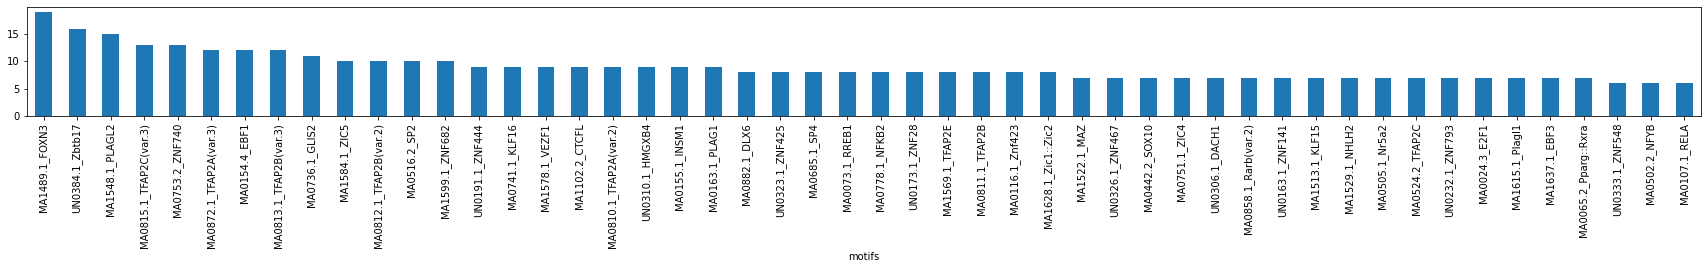

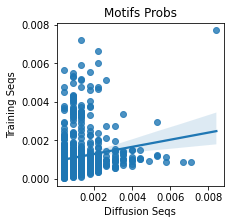

12 3 0.4208883420494251


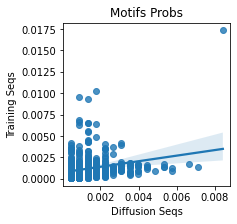

12 8 0.39787988243064376


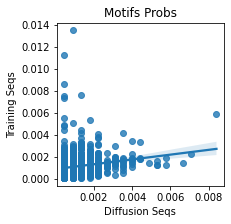

12 12 0.4473981168102078


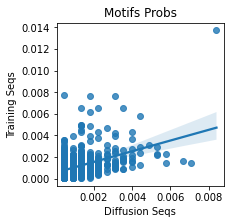

12 15 0.2902378475413563
15


<ipython-input-33-a1ea37b0f7ed>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.46it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.44it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.62it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


specific
started
10
first



sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


scanning: 100% 200/200 [00:05<00:00, 34.34 sequences/s]


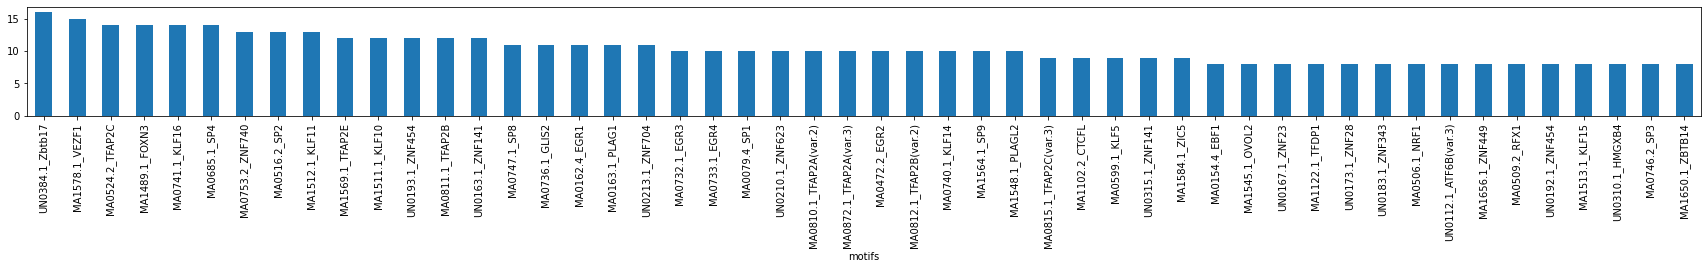

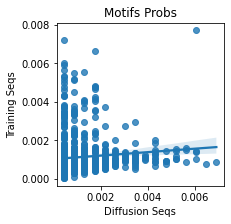

15 3 0.47255952369954557


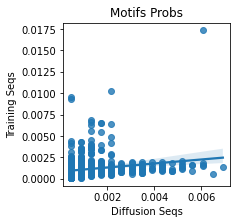

15 8 0.41436044260240606


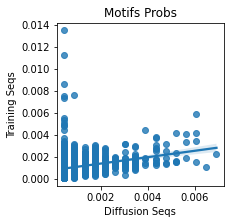

15 12 0.37725528741268993


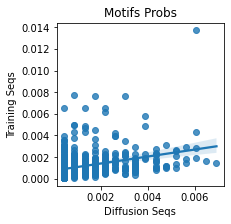

15 15 0.3637061344352772


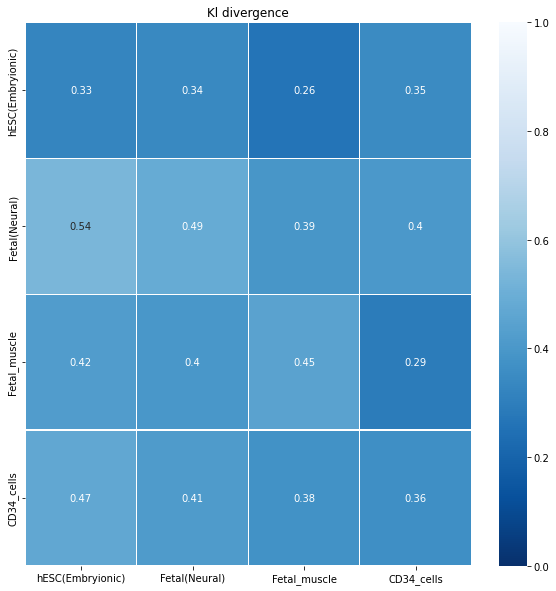

In [47]:
use_comp = [3, 8, 12, 15]

heat_new_sequences_test = kl_comparison_generated_sequences(use_comp, final_comp_values_train)